# How to get a good score with only 31 features

Inspired by the really cool kernel "Distance - is all you need" (https://www.kaggle.com/criskiev/distance-is-all-you-need-lb-1-481), I tried to devise my own system of simple, geomtric features.

## Steps

* Calculate the center-point on the axis between the two j-coupled atoms
  (let's refer to them as atom_0 and and atom_1)
* Get the 10 closet atoms and rank them by their distance to the center point (from closest to farthest away)
* For each of the 10-nearest neighbor atoms calculate the angle between this atom, the center-point and atom_1. 


## Features
Now, or each of the 10-nearest neighbor atoms, we have 3 features:

* atom-type
* distance from the center
* angle between atom, center-point and atom_1 (using the cosine, the feature is automatically scaled between 1 and -1)
   
Throw in the distance between atom_0 and atom_1 and we have our 31 features.

    
## Intuition

These features provide three sources of information:

* Which atom: H, C, N, O, or F
* How far away from the j-coupled atoms
* Which side of the interactions: 
    - close to 1:  side of atom_1
    - close to -1: side of atom_0
    - close to 0:  equal distance to both (in-between)
    
Essentially, what we got is a 2C polar-coordinate system centered around the center-point between atom_0 and atom_1.  
The only thing missing for a 3D poloar-coordinate system representing the whole molecular geometry would be to add the angle of rotion around the atom_0-atom_1 axis.  
See next section, why this wasn't done :-)


## Model

The same LGBM used in the above mentioned kernel.  
Only more estimators are used for test-set prediction

## Limitations

The decent score given the simple features suggests that geometry and atom type is all you need (it's also all you got ... :-D).
However, this simple approach suffers from two main drawbacks:

#### Permutation
  A small difference in distances can lead to a different order of neighbor-atoms. This way very similar geometries can end up a different feature ordering which impedes learning.
... that's why Message Passing Neural Networks or Graph Neural networks are used: the employ permutation invariant aggregation functions, such as $sum$ or $mean$.
  
#### No feature structure

Note that the 31 features above are not simply 31 scalar features. Obviously there is some structure:
For each atom, the features type, distance and cosine belong togheter (actually it's more like a single, vector valued feature rather than 3 features).  
However, the model can't account for this structure when it's simply provided a list of features. For this reason, adding even more features to this approach would probably not lead to substantial improvements.

## Runtime

It takes forever.  
The computation was not optimized due to the inherent limitations of the approach explained above :-)
  


In [1]:
%%capture

import os
from os.path import join
import sys
from pprint import pprint

import numpy as np
from numpy.linalg import norm
import pandas as pd
import matplotlib.pyplot as plt

from scipy.spatial import distance_matrix

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

DATA_DIR = '../input/champs-scalar-coupling'
ATOMIC_NUMBERS = {
    'H': 1,
    'C': 6,
    'N': 7,
    'O': 8,
    'F': 9
}

# Load Data

In [2]:
structures_dtypes = {
    'molecule_name': 'category',
    'atom_index': 'int8',
    'atom': 'category',
    'x': 'float32',
    'y': 'float32',
    'z': 'float32'
}
structures_df = pd.read_csv(join(DATA_DIR, 'structures.csv'), dtype=structures_dtypes)

structures_df['molecule_index'] = structures_df.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
structures_df['atom'] = structures_df['atom'].replace(ATOMIC_NUMBERS).astype('int8')
structures_df.index = structures_df.molecule_index
structures_df = structures_df[['atom_index', 'atom', 'x', 'y', 'z']]

structures_df[['x', 'y', 'z']] = structures_df[['x', 'y', 'z']] / 10  # puts all distances approx. in range [0, 1]
print(structures_df.shape)
display(structures_df.head())

(2358657, 5)


,atom_index,atom,x,y,z
molecule_index,,,,,
1,0,6,-0.001270,0.108580,0.000800
1,1,1,0.000215,-0.000603,0.000198
1,2,1,0.101173,0.146375,0.000028
1,3,1,-0.054082,0.144753,-0.087664
1,4,1,-0.052381,0.143793,0.090640


In [3]:
def load_j_coupling_csv(file_path: str, train=True, verbose=False):
    train_dtypes = {
        'molecule_name': 'category',
        'atom_index_0': 'int8',
        'atom_index_1': 'int8',
        'type': 'category',
        'scalar_coupling_constant': 'float32'
    }
    df = pd.read_csv(file_path, dtype=train_dtypes)
    df['molecule_index'] = df.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
    
    if train:
        cols = ['id', 'molecule_index', 'atom_index_0', 'atom_index_1', 'type', 'scalar_coupling_constant']
    else: 
        cols = ['id', 'molecule_index', 'atom_index_0', 'atom_index_1', 'type']
    df = df[cols]

    if verbose:
        print(df.shape)
        display(df.head())
        
    return df
    
train_df = load_j_coupling_csv(join(DATA_DIR, 'train.csv'), verbose=True)

mol2distance_matrix = structures_df.groupby('molecule_index').apply(
    lambda df: distance_matrix(df[['x','y', 'z']].values, df[['x','y', 'z']].values))

(4658147, 6)


,id,molecule_index,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,1,1,0,1JHC,84.807602
1,1,1,1,2,2JHH,-11.257000
2,2,1,1,3,2JHH,-11.254800
3,3,1,1,4,2JHH,-11.254300
4,4,1,2,0,1JHC,84.807404


# Calculate Features

In [4]:
def get_center(p0: np.array, p1: np.array) -> np.array:
    return p0 + (p1 - p0)/2


def get_vector(p0: np.array, p1: np.array) -> np.array:
    return p1 - p0


def calc_cosines(coords: np.array, a0: int, a1: int) -> np.array:
    """
    @coordinates:
    atom    x     y     z
    1       1     2     3
    2       4     5     6
    ...
    """
    atom_axes = coords - get_center(coords[a0, :], coords[a1, :])
    main_axis = get_vector(coords[a0, :], coords[a1, :])
    
    dot_products = np.dot(atom_axes, main_axis)
    atom_axes_norms = np.apply_along_axis(norm, 1, atom_axes)
    main_axis_norm = norm(main_axis)
    
    return dot_products / (atom_axes_norms * main_axis_norm)


def get_knn_coordinates(j_coupling: pd.Series,
                        structures=structures_df,
                        mol2dist=mol2distance_matrix,
                        k=10) -> np.array:
    
    a_0, a_1 = j_coupling.atom_index_0, j_coupling.atom_index_1
    mol_df   = structures.loc[j_coupling.molecule_index]
    
    coordinates = mol_df[['x','y', 'z']].values
    a0_coords   = coordinates[a_0, :]
    a1_coords   = coordinates[a_1, :]
    center      = get_center(a0_coords, a1_coords)
    
    cosines = calc_cosines(coordinates, a_0, a_1)
    
    center_distances = distance_matrix(center.reshape(1, 3), coordinates).ravel()
    knn = np.argsort(center_distances)[:(k + 2)]  # atom-indices of KNN-atoms
    
    knn = np.array([x for x in knn if x not in (a_0, a_1)])
    
    distances = center_distances[knn]
    cosines   = cosines[knn]
    types = mol_df.iloc[knn].atom
    
    distances = np.pad(distances, (0, k - len(distances)), 'constant')
    cosines   = np.pad(cosines,   (0, k - len(cosines)),   'constant')
    types     = np.pad(types,     (0, k - len(types)),     'constant')
    
    d_a0_a1 = norm(a1_coords - a0_coords)

    return np.concatenate([[d_a0_a1], distances, cosines, types])


# this may take a while...
id2features = {row.id : get_knn_coordinates(row) for _, row in train_df.iterrows()}

# Make Model

In [5]:
def make_data(df: pd.DataFrame, id2features: dict, random_state=128, split=True):
    tmp_df = df.copy()
    tmp_df['features'] = tmp_df.id.map(id2features)
    
    X = np.stack(tmp_df.features)
    y = tmp_df.scalar_coupling_constant.values

    if split:
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=random_state)
        return (X_train, y_train), (X_val, y_val)
    else:
        return X, y

    
# hyper-parameters like in this kernel:
# https://www.kaggle.com/criskiev/distance-is-all-you-need-lb-1-481
LGB_PARAMS = {
        'objective': 'regression',
        'metric': 'mae',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': 0.2,
        'num_leaves': 128,
        'min_child_samples': 79,
        'max_depth': 9,
        'subsample_freq': 1,
        'subsample': 0.9,
        'bagging_seed': 11,
        'reg_alpha': 0.1,
        'reg_lambda': 0.3,
        'colsample_bytree': 1.0
        }

    
def train_model(train, validation):
    
    X_train, y_train = train
    X_val,   y_val   = validation

    model = LGBMRegressor(**LGB_PARAMS, n_estimators=1500, n_jobs = -1)  # 6000 estimators would be better but take much longer
    model.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='mae',
            verbose=100, early_stopping_rounds=200)

    y_pred    = model.predict(X_val)
    score     = np.log(mean_absolute_error(y_val, y_pred))
    residuals = y_val - y_pred
    
    print(f'competition-metric score: {score}')
    return model, score, residuals


def plot_residuals(residuals: np.array):
    plt.hist(residuals, bins=50)
    plt.title('residual distribution')
    plt.show();

(34690, 31) (8673, 31) (34690,) (8673,)
Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.448225	valid_1's l1: 0.570783
[200]	training's l1: 0.359946	valid_1's l1: 0.519412
[300]	training's l1: 0.301587	valid_1's l1: 0.48905
[400]	training's l1: 0.260787	valid_1's l1: 0.470359
[500]	training's l1: 0.229345	valid_1's l1: 0.458981
[600]	training's l1: 0.201949	valid_1's l1: 0.450218
[700]	training's l1: 0.177991	valid_1's l1: 0.443445
[800]	training's l1: 0.158559	valid_1's l1: 0.438351
[900]	training's l1: 0.141324	valid_1's l1: 0.433221
[1000]	training's l1: 0.127862	valid_1's l1: 0.431203
[1100]	training's l1: 0.116296	valid_1's l1: 0.428626
[1200]	training's l1: 0.105711	valid_1's l1: 0.426672
[1300]	training's l1: 0.0963767	valid_1's l1: 0.424798
[1400]	training's l1: 0.0879855	valid_1's l1: 0.423175
[1500]	training's l1: 0.0804111	valid_1's l1: 0.421794
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.0804111	valid_1's l1: 

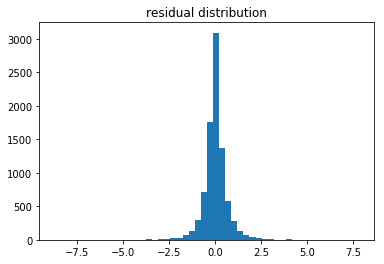

In [6]:
# test pipeline with smallest type:

sub_train_df = train_df.query('type == "1JHN"')

(X_train, y_train), (X_val, y_val) = make_data(sub_train_df, id2features)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

model, score, residuals = train_model((X_train, y_train), (X_val, y_val))
plot_residuals(residuals)

# Cross-validate



### 1JHC
Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 1.21437	valid_1's l1: 1.2623
[200]	training's l1: 1.01695	valid_1's l1: 1.09564
[300]	training's l1: 0.915588	valid_1's l1: 1.01881
[400]	training's l1: 0.844311	valid_1's l1: 0.96888
[500]	training's l1: 0.789861	valid_1's l1: 0.933285
[600]	training's l1: 0.744869	valid_1's l1: 0.90643
[700]	training's l1: 0.706355	valid_1's l1: 0.88447
[800]	training's l1: 0.675311	valid_1's l1: 0.867806
[900]	training's l1: 0.647279	valid_1's l1: 0.852934
[1000]	training's l1: 0.622204	valid_1's l1: 0.840379
[1100]	training's l1: 0.599179	valid_1's l1: 0.829402
[1200]	training's l1: 0.577726	valid_1's l1: 0.819427
[1300]	training's l1: 0.557945	valid_1's l1: 0.810295
[1400]	training's l1: 0.540106	valid_1's l1: 0.802522
[1500]	training's l1: 0.523479	valid_1's l1: 0.79531
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.523479	valid_1's l1: 0.79531
competition-metric score: -0.22902

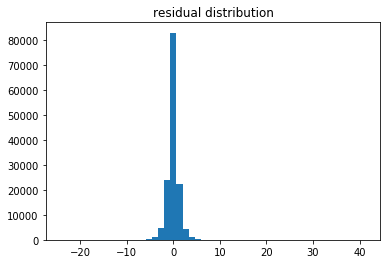



### 1JHN
Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.448225	valid_1's l1: 0.570783
[200]	training's l1: 0.359946	valid_1's l1: 0.519412
[300]	training's l1: 0.301587	valid_1's l1: 0.48905
[400]	training's l1: 0.260787	valid_1's l1: 0.470359
[500]	training's l1: 0.229345	valid_1's l1: 0.458981
[600]	training's l1: 0.201949	valid_1's l1: 0.450218
[700]	training's l1: 0.177991	valid_1's l1: 0.443445
[800]	training's l1: 0.158559	valid_1's l1: 0.438351
[900]	training's l1: 0.141324	valid_1's l1: 0.433221
[1000]	training's l1: 0.127862	valid_1's l1: 0.431203
[1100]	training's l1: 0.116296	valid_1's l1: 0.428626
[1200]	training's l1: 0.105711	valid_1's l1: 0.426672
[1300]	training's l1: 0.0963767	valid_1's l1: 0.424798
[1400]	training's l1: 0.0879855	valid_1's l1: 0.423175
[1500]	training's l1: 0.0804111	valid_1's l1: 0.421794
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.0804111	valid_1's l1: 0.421794
competition-metric s

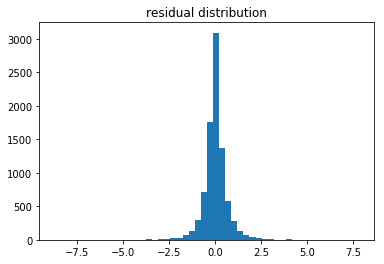



### 2JHC
Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.555766	valid_1's l1: 0.574333
[200]	training's l1: 0.470642	valid_1's l1: 0.498336
[300]	training's l1: 0.425388	valid_1's l1: 0.460763
[400]	training's l1: 0.394917	valid_1's l1: 0.437354
[500]	training's l1: 0.371887	valid_1's l1: 0.420454
[600]	training's l1: 0.352645	valid_1's l1: 0.406602
[700]	training's l1: 0.336305	valid_1's l1: 0.39578
[800]	training's l1: 0.322616	valid_1's l1: 0.387141
[900]	training's l1: 0.310312	valid_1's l1: 0.379431
[1000]	training's l1: 0.299604	valid_1's l1: 0.372987
[1100]	training's l1: 0.289728	valid_1's l1: 0.367143
[1200]	training's l1: 0.280736	valid_1's l1: 0.361995
[1300]	training's l1: 0.272349	valid_1's l1: 0.357208
[1400]	training's l1: 0.264599	valid_1's l1: 0.353142
[1500]	training's l1: 0.257472	valid_1's l1: 0.349513
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.257472	valid_1's l1: 0.349513
competition-metric score

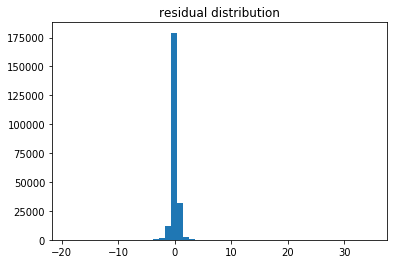



### 2JHH
Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.259549	valid_1's l1: 0.283273
[200]	training's l1: 0.213292	valid_1's l1: 0.248024
[300]	training's l1: 0.187371	valid_1's l1: 0.231501
[400]	training's l1: 0.169524	valid_1's l1: 0.221444
[500]	training's l1: 0.156122	valid_1's l1: 0.214745
[600]	training's l1: 0.145149	valid_1's l1: 0.20929
[700]	training's l1: 0.135976	valid_1's l1: 0.205114
[800]	training's l1: 0.127888	valid_1's l1: 0.201644
[900]	training's l1: 0.12093	valid_1's l1: 0.198901
[1000]	training's l1: 0.114531	valid_1's l1: 0.196657
[1100]	training's l1: 0.108999	valid_1's l1: 0.194713
[1200]	training's l1: 0.103777	valid_1's l1: 0.192946
[1300]	training's l1: 0.0990141	valid_1's l1: 0.191389
[1400]	training's l1: 0.0944662	valid_1's l1: 0.190015
[1500]	training's l1: 0.0904313	valid_1's l1: 0.188741
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.0904313	valid_1's l1: 0.188741
competition-metric sc

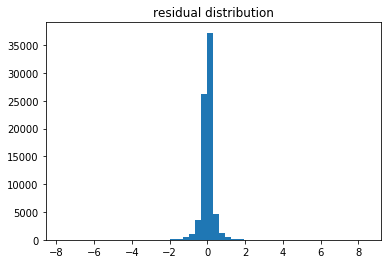



### 2JHN
Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.199125	valid_1's l1: 0.237363
[200]	training's l1: 0.161081	valid_1's l1: 0.210972
[300]	training's l1: 0.137909	valid_1's l1: 0.197283
[400]	training's l1: 0.121734	valid_1's l1: 0.189056
[500]	training's l1: 0.109575	valid_1's l1: 0.183216
[600]	training's l1: 0.0993136	valid_1's l1: 0.1785
[700]	training's l1: 0.0910976	valid_1's l1: 0.175304
[800]	training's l1: 0.0832616	valid_1's l1: 0.172344
[900]	training's l1: 0.0765566	valid_1's l1: 0.169826
[1000]	training's l1: 0.0710681	valid_1's l1: 0.168089
[1100]	training's l1: 0.0659219	valid_1's l1: 0.16653
[1200]	training's l1: 0.0613758	valid_1's l1: 0.165102
[1300]	training's l1: 0.0573022	valid_1's l1: 0.163969
[1400]	training's l1: 0.0536416	valid_1's l1: 0.162838
[1500]	training's l1: 0.0504336	valid_1's l1: 0.162084
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.0504336	valid_1's l1: 0.162084
competition-met

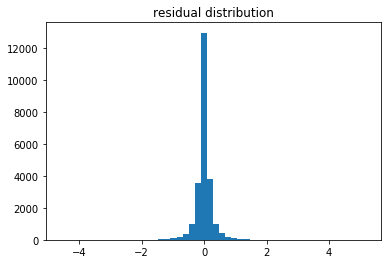



### 3JHC
Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.555474	valid_1's l1: 0.564716
[200]	training's l1: 0.4825	valid_1's l1: 0.499324
[300]	training's l1: 0.442407	valid_1's l1: 0.465289
[400]	training's l1: 0.412663	valid_1's l1: 0.440789
[500]	training's l1: 0.391397	valid_1's l1: 0.424369
[600]	training's l1: 0.373605	valid_1's l1: 0.410997
[700]	training's l1: 0.359378	valid_1's l1: 0.400792
[800]	training's l1: 0.346828	valid_1's l1: 0.392226
[900]	training's l1: 0.335416	valid_1's l1: 0.384481
[1000]	training's l1: 0.325113	valid_1's l1: 0.377776
[1100]	training's l1: 0.316091	valid_1's l1: 0.371972
[1200]	training's l1: 0.307894	valid_1's l1: 0.366927
[1300]	training's l1: 0.300179	valid_1's l1: 0.362207
[1400]	training's l1: 0.293113	valid_1's l1: 0.358049
[1500]	training's l1: 0.28651	valid_1's l1: 0.354158
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.28651	valid_1's l1: 0.354158
competition-metric score: -

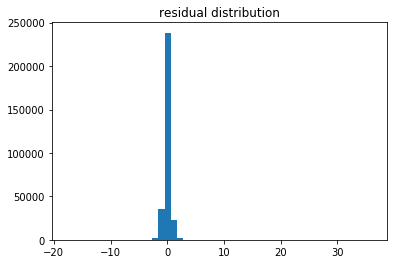



### 3JHH
Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.264523	valid_1's l1: 0.275707
[200]	training's l1: 0.220535	valid_1's l1: 0.239119
[300]	training's l1: 0.197616	valid_1's l1: 0.22215
[400]	training's l1: 0.181191	valid_1's l1: 0.211276
[500]	training's l1: 0.168424	valid_1's l1: 0.203057
[600]	training's l1: 0.158312	valid_1's l1: 0.197293
[700]	training's l1: 0.149791	valid_1's l1: 0.192462
[800]	training's l1: 0.142366	valid_1's l1: 0.188298
[900]	training's l1: 0.135951	valid_1's l1: 0.185056
[1000]	training's l1: 0.13012	valid_1's l1: 0.182215
[1100]	training's l1: 0.124973	valid_1's l1: 0.17981
[1200]	training's l1: 0.120197	valid_1's l1: 0.177675
[1300]	training's l1: 0.115826	valid_1's l1: 0.175843
[1400]	training's l1: 0.111887	valid_1's l1: 0.174129
[1500]	training's l1: 0.108186	valid_1's l1: 0.172637
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.108186	valid_1's l1: 0.172637
competition-metric score: 

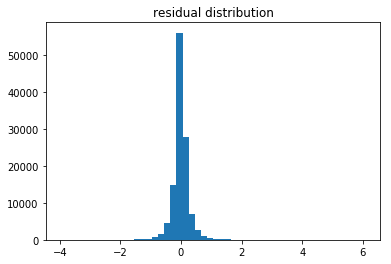



### 3JHN
Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 0.1588	valid_1's l1: 0.181072
[200]	training's l1: 0.128359	valid_1's l1: 0.159441
[300]	training's l1: 0.110737	valid_1's l1: 0.148978
[400]	training's l1: 0.0983434	valid_1's l1: 0.14231
[500]	training's l1: 0.0879531	valid_1's l1: 0.137082
[600]	training's l1: 0.0800577	valid_1's l1: 0.133605
[700]	training's l1: 0.0735362	valid_1's l1: 0.130845
[800]	training's l1: 0.0682512	valid_1's l1: 0.128671
[900]	training's l1: 0.0633959	valid_1's l1: 0.126845
[1000]	training's l1: 0.0591158	valid_1's l1: 0.125244
[1100]	training's l1: 0.0553719	valid_1's l1: 0.123988
[1200]	training's l1: 0.0520534	valid_1's l1: 0.122892
[1300]	training's l1: 0.049104	valid_1's l1: 0.121953
[1400]	training's l1: 0.0463951	valid_1's l1: 0.121178
[1500]	training's l1: 0.0438147	valid_1's l1: 0.120398
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.0438147	valid_1's l1: 0.120398
competition-me

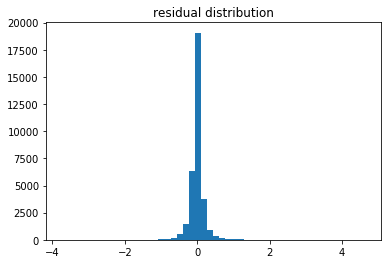

In [7]:
def cross_validate(df, id2features):
    type2model = {}
    scores = {}

    for type_, type_df in df.groupby('type'):
        print(f'\n\n### {type_}')
        train, validation = make_data(type_df, id2features)
        model, score, residuals = train_model(train, validation)
        type2model[type_] = model
        scores[type_] = score
        plot_residuals(residuals)

    assert len(scores) == len(type2model) == 8
    return  scores


scores = cross_validate(train_df, id2features)

In [8]:
print(f'competition-metric: {np.mean(list(scores.values())):.2f}')
print('scores per type:')
pprint(scores, width=1)

competition-metric: -1.32
scores per type:
{'1JHC': -0.22902319461463033,
 '1JHN': -0.8632384722939297,
 '2JHC': -1.0512146326105318,
 '2JHH': -1.6673793268867814,
 '2JHN': -1.819638295873539,
 '3JHC': -1.0380134514615706,
 '3JHH': -1.7565626748911474,
 '3JHN': -2.1169488392536437}


# Predict and submit

In [9]:
def make_test_data(df: pd.DataFrame, id2features: dict, random_state=128):
    tmp_df = df.copy()
    tmp_df['features'] = tmp_df.id.map(id2features)
    X = np.stack(tmp_df.features)
    return X


test_df = load_j_coupling_csv(join(DATA_DIR, 'test.csv'), train=False, verbose=True)
id2features_test = {row.id : get_knn_coordinates(row) for _, row in test_df.iterrows()}
prediction_df = pd.DataFrame()


for type_ in sorted(train_df.type.unique()):
    print(f'\n### {type_}')
    
    train_type_df = train_df.query('type == @type_')
    X_train, y_train = make_data(train_type_df, id2features, split=False)
    model = LGBMRegressor(**LGB_PARAMS, n_estimators=2000, n_jobs = -1)  # more estimators for test-set
    model.fit(X_train, y_train, eval_metric='mae')
    
    test_type_df = test_df.query('type == @type_')
    X_test = make_test_data(test_type_df, id2features_test)
    y_hat  = model.predict(X_test)
    
    type_pred_df  = pd.DataFrame({'id': test_type_df.id, 'scalar_coupling_constant': y_hat})
    prediction_df = pd.concat([prediction_df, type_pred_df], ignore_index=True)

(2505542, 5)


,id,molecule_index,atom_index_0,atom_index_1,type
0,4658147,4,2,0,2JHC
1,4658148,4,2,1,1JHC
2,4658149,4,2,3,3JHH
3,4658150,4,3,0,1JHC
4,4658151,4,3,1,2JHC



### 1JHC

### 1JHN

### 2JHC

### 2JHH

### 2JHN

### 3JHC

### 3JHH

### 3JHN


In [10]:
prediction_df = prediction_df.sort_values('id')
prediction_df.to_csv('submission.csv', index=False)

In [11]:
assert len(prediction_df) == len(test_df)
print(prediction_df.shape)
display(prediction_df.head())

(2505542, 2)


,id,scalar_coupling_constant
404804,4658147,11.265111
0,4658148,173.456840
2097491,4658149,11.479863
1,4658150,173.456840
404805,4658151,11.265111
